In [22]:
import csv
import matplotlib.pyplot as plt

from random import randrange
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, row_number, collect_list
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

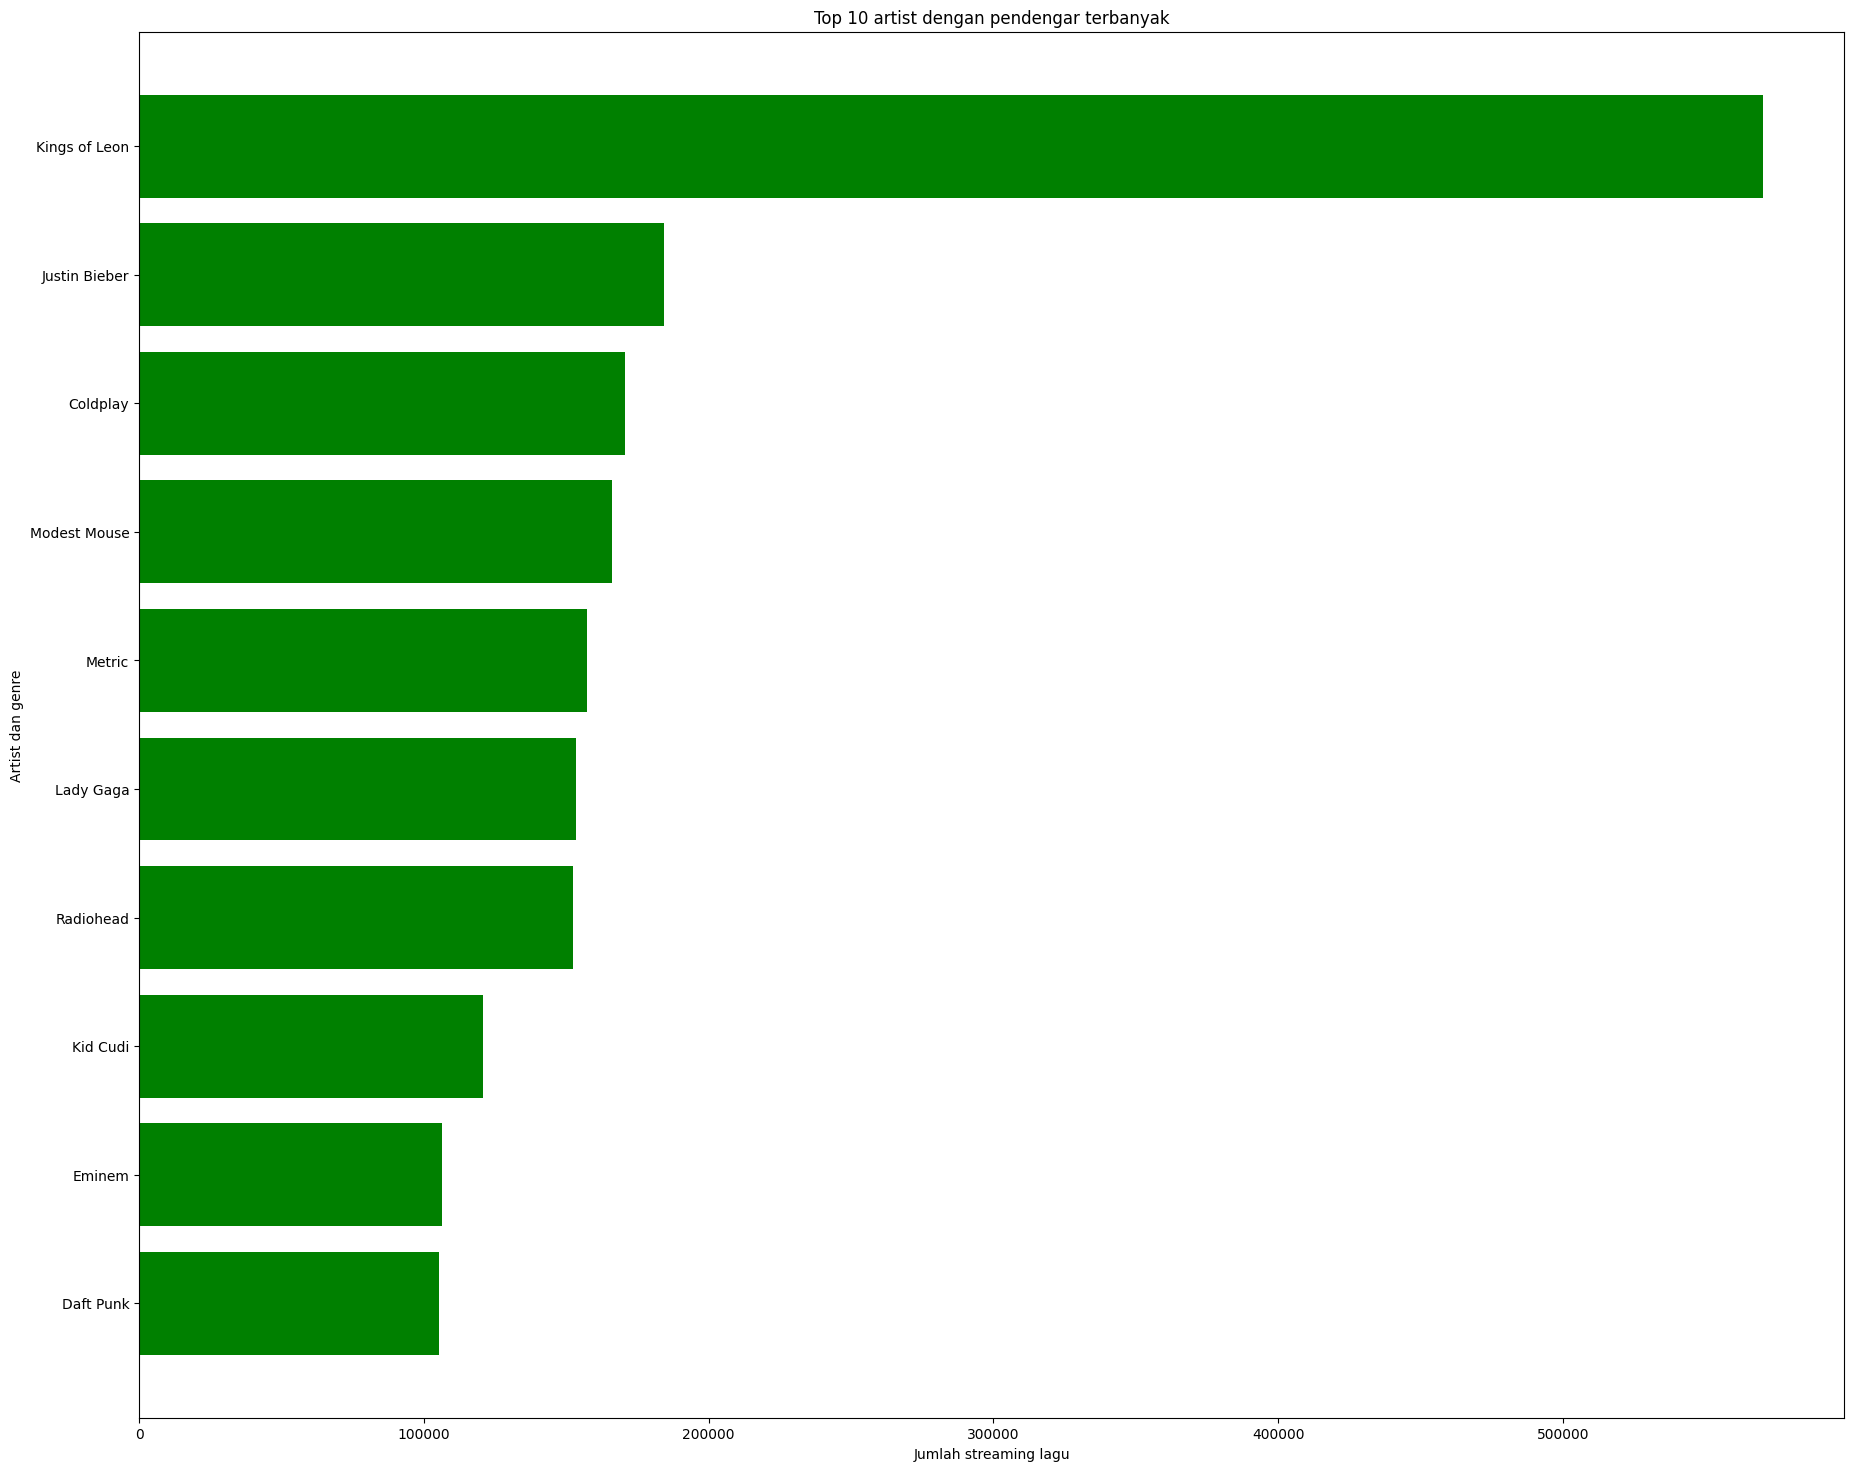

In [19]:
occurrences = []
artist_and_category = []

# Baca data
with open('merged/merged_data.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        occurrences.append(int(row['occurrences']))
        artist_and_category.append(f"{row['artist']}")
        if occurrences.__len__() > 9:
            break

# Plotting
plt.figure(figsize=(22, 18))
plt.barh(artist_and_category, occurrences, color='green')
plt.xlabel('Jumlah streaming lagu')
plt.ylabel('Artist dan genre')
plt.title('Top 10 artist dengan pendengar terbanyak')
plt.gca().invert_yaxis()
plt.show()

+----------+-----------------+
|     genre|total_occurrences|
+----------+-----------------+
|     World|            54091|
|     Latin|            74884|
|     Metal|           846604|
|      Rock|          8808231|
|      Jazz|           188157|
|   New Age|           171075|
|      Folk|           389822|
|       RnB|           363087|
|     Blues|            37240|
|       Pop|          1484501|
|      Punk|           170658|
|       Rap|           891687|
|    Reggae|           191751|
|Electronic|          1975595|
|   Country|           697086|
+----------+-----------------+



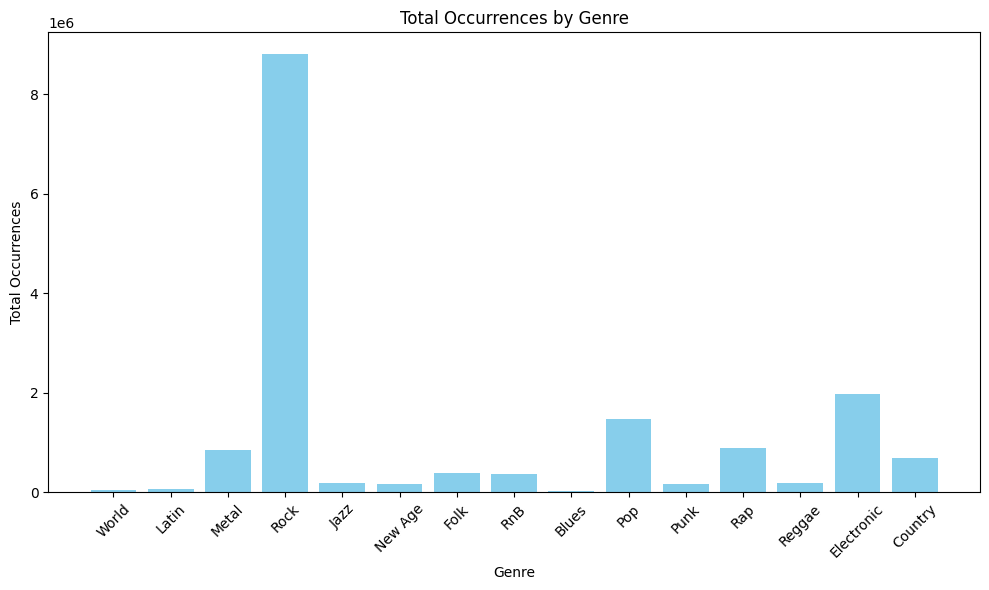

In [20]:
spark = SparkSession.builder.appName("MusicDataProcessing").getOrCreate()
file_path = "merged/merged_data.csv"

df = spark.read.csv(file_path, header=True, inferSchema=True)

# Group by genre
genre_grouped = df.groupBy("genre").agg(_sum("occurrences").alias("total_occurrences"))
genre_grouped.show()

# Convert ke Pandas DataFrame untuk plotting
genre_grouped_pd = genre_grouped.toPandas()

# Plot genre
plt.figure(figsize=(10, 6))
plt.bar(genre_grouped_pd['genre'], genre_grouped_pd['total_occurrences'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Total Occurrences')
plt.title('Total Occurrences by Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

spark.stop()

+----------------+----------+-----------+--------------------+
|          artist|     genre|occurrences|          track_name|
+----------------+----------+-----------+--------------------+
|       B.B. King|     Blues|       8979|   It's My Own Fault|
|  Rory Gallagher|     Blues|       4111|       Tattoo'd Lady|
|   The Yardbirds|     Blues|       3728|           I'm A Man|
|    Depeche Mode|     Blues|       3019|           Lie To Me|
|   T-Bone Walker|     Blues|       2937|      Mean Old World|
|    Taylor Swift|   Country|      63830|A Perfectly Good ...|
|      Toby Keith|   Country|      54333|You Shouldn't Kis...|
|      Luke Bryan|   Country|      48717|          Tackle Box|
|Billy Currington|   Country|      43072|Must Be Doin' Som...|
|     Eric Church|   Country|      33825|   What I Almost Was|
|       Daft Punk|Electronic|     105469|        Digital Love|
|     The Prodigy|Electronic|      66838|Thunder (Bang Gan...|
| LCD Soundsystem|Electronic|      64208|Yeah (Pretenti

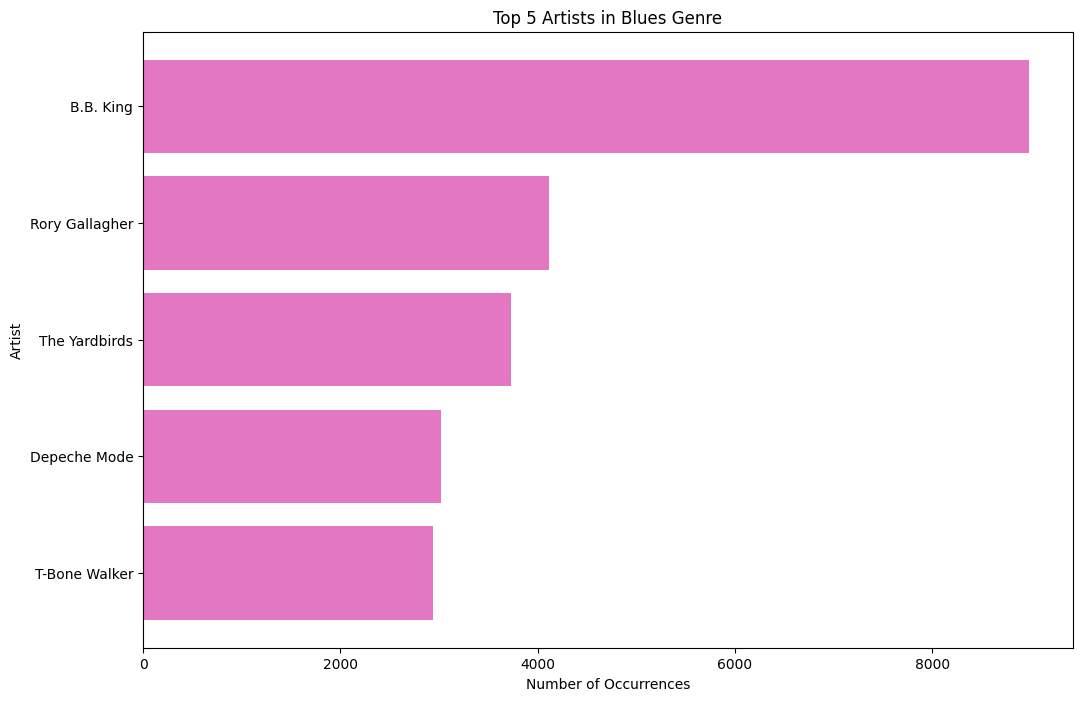

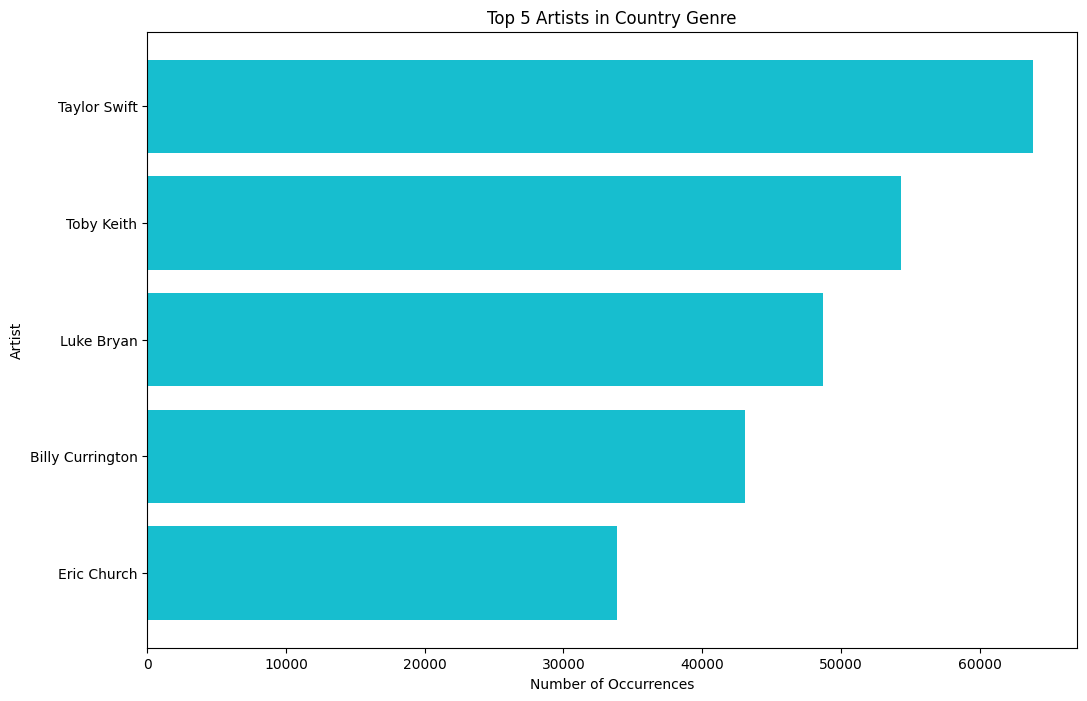

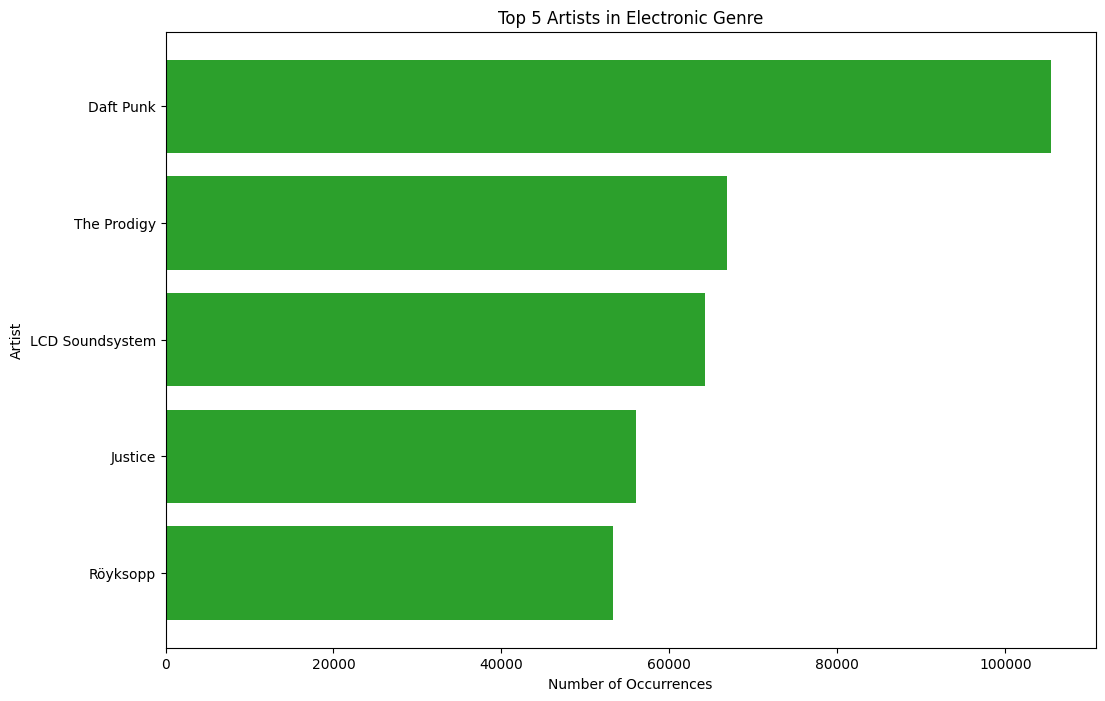

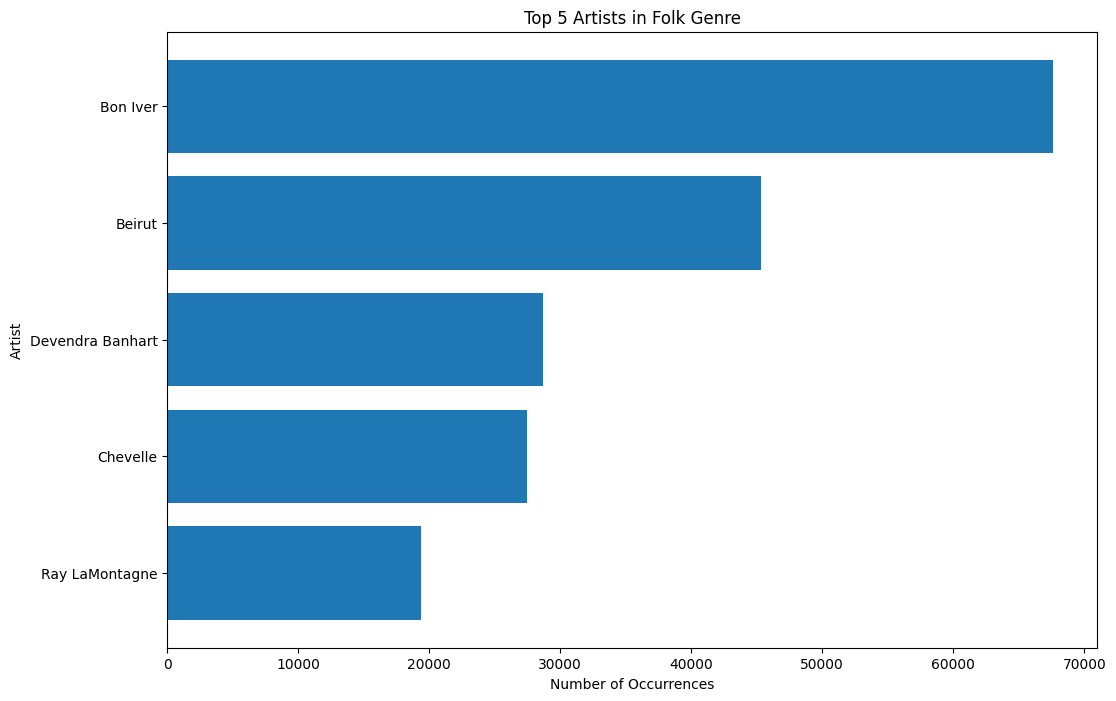

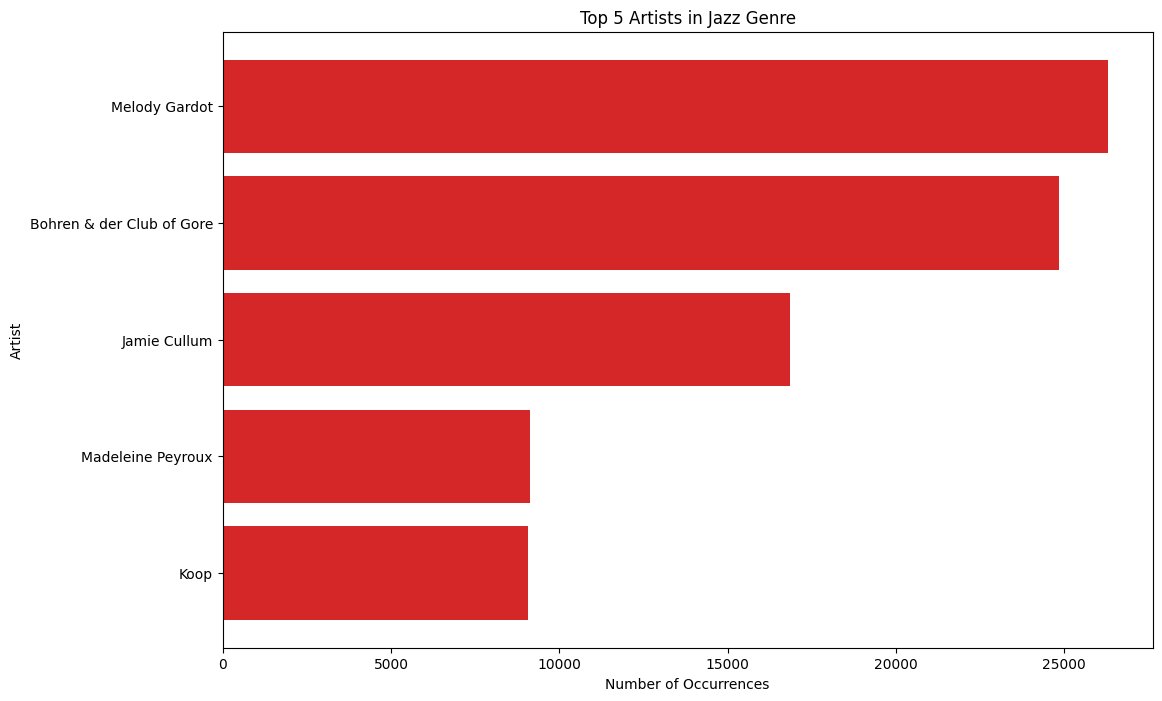

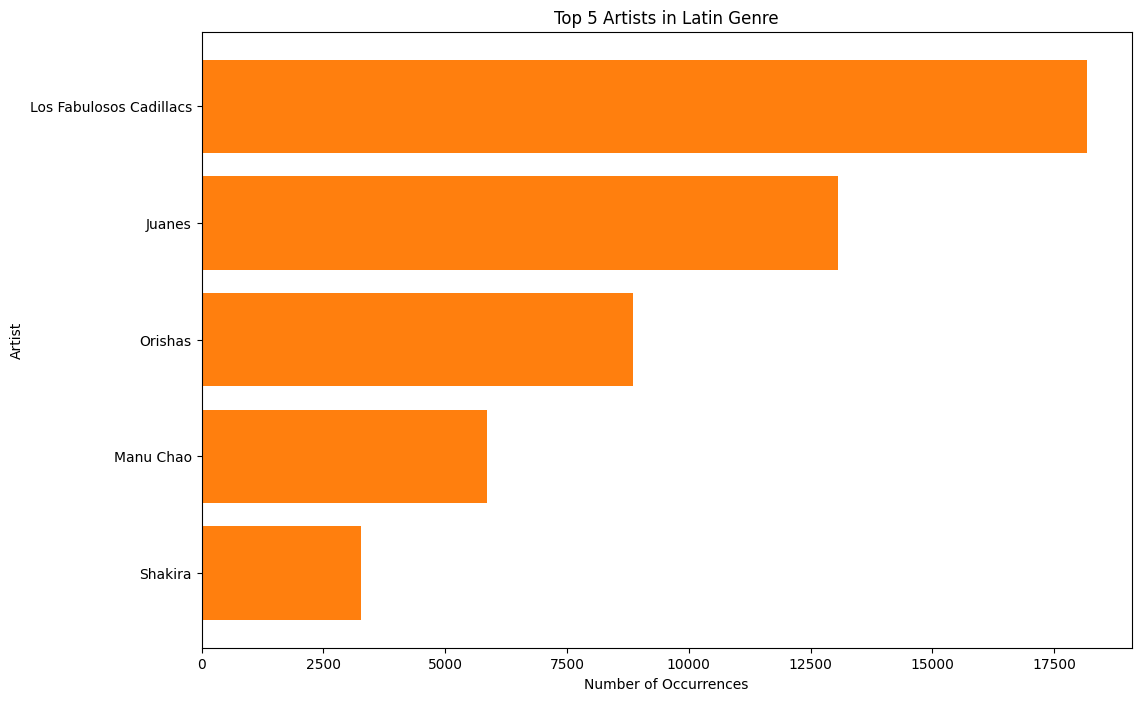

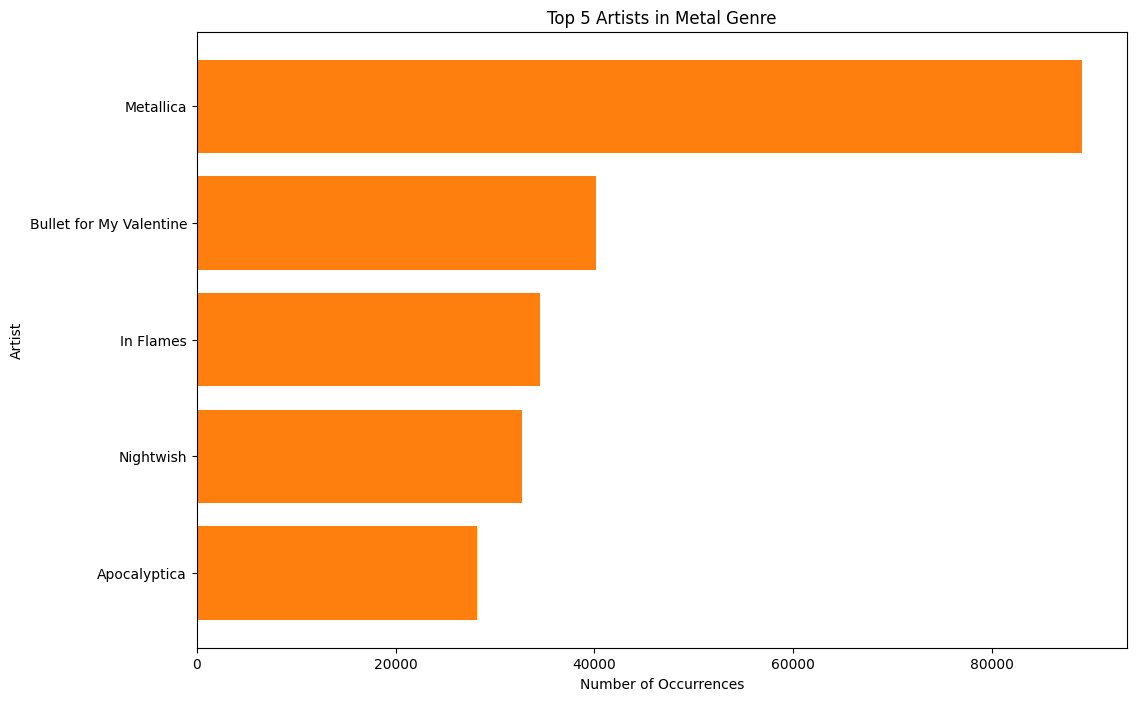

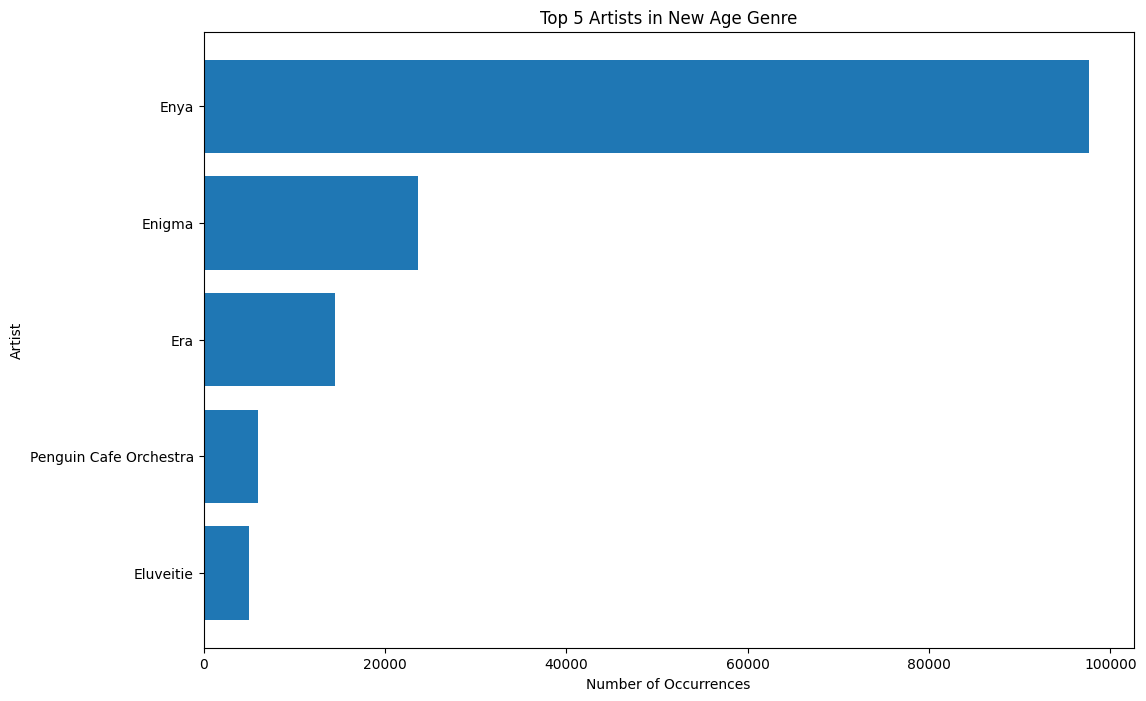

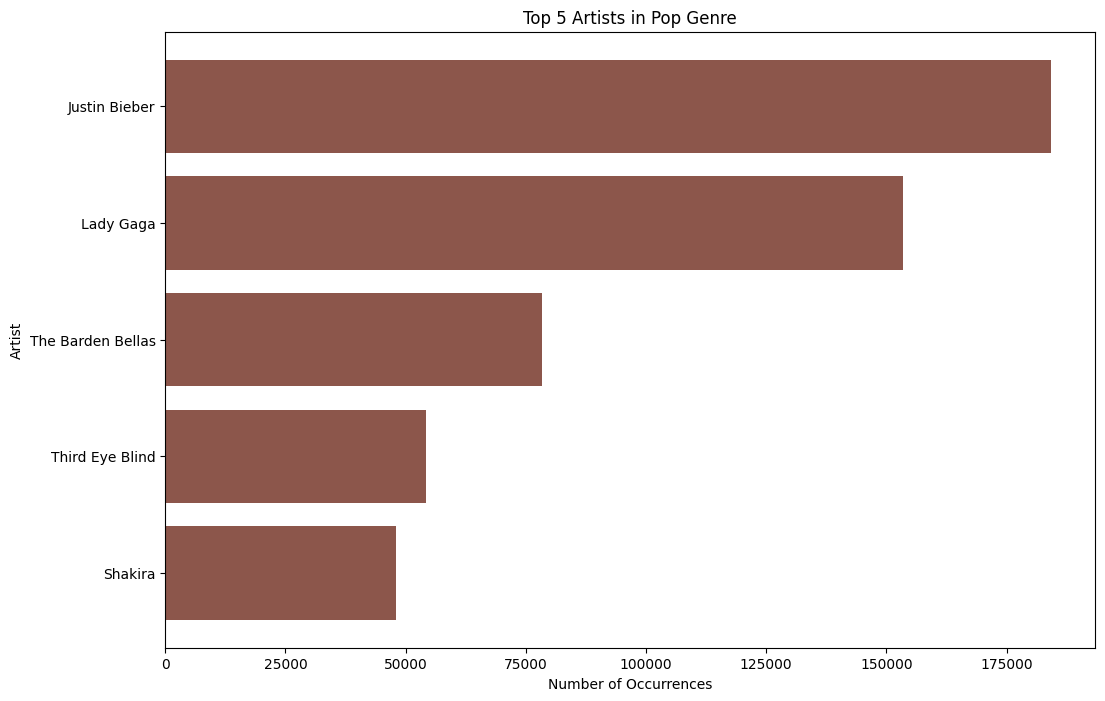

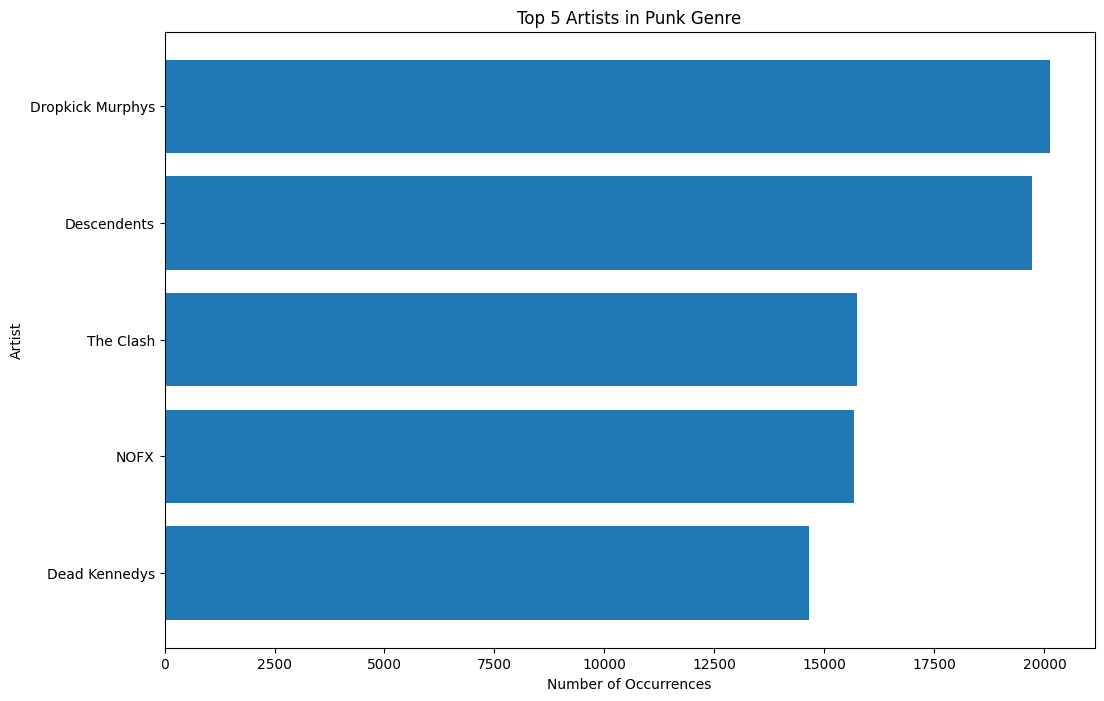

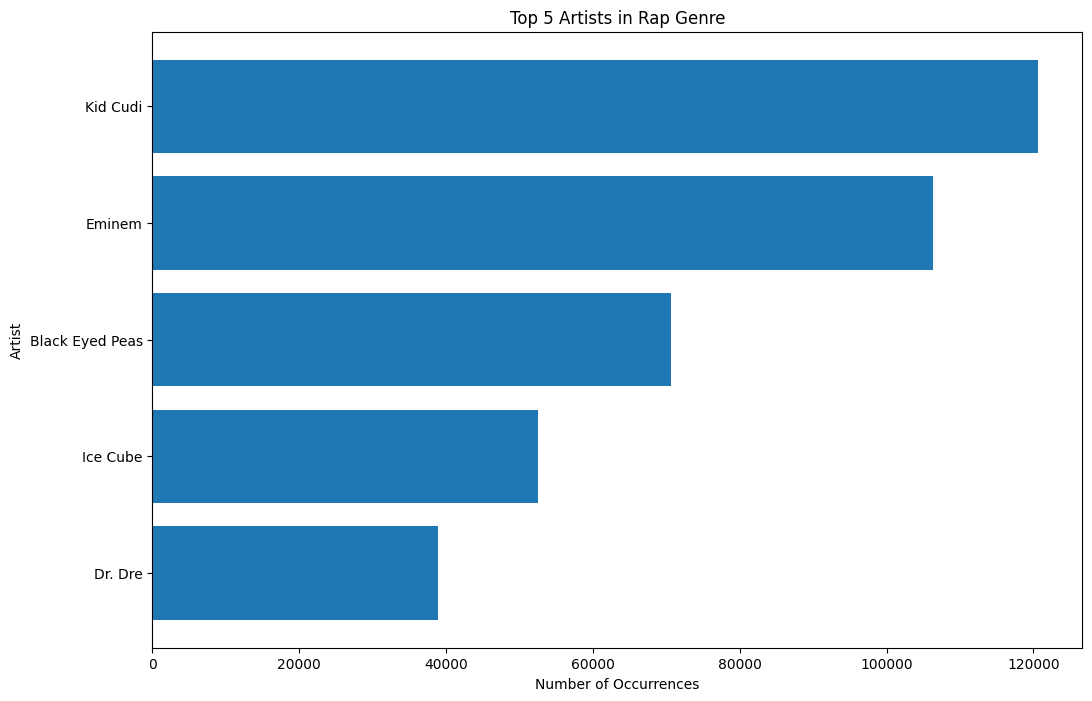

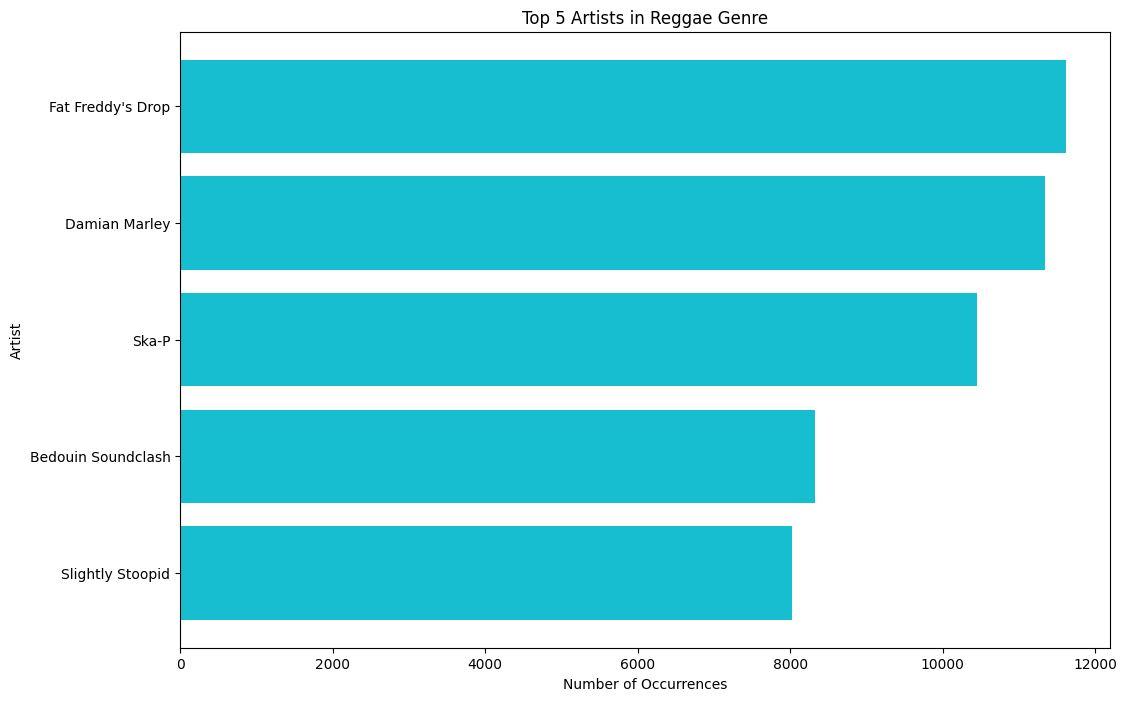

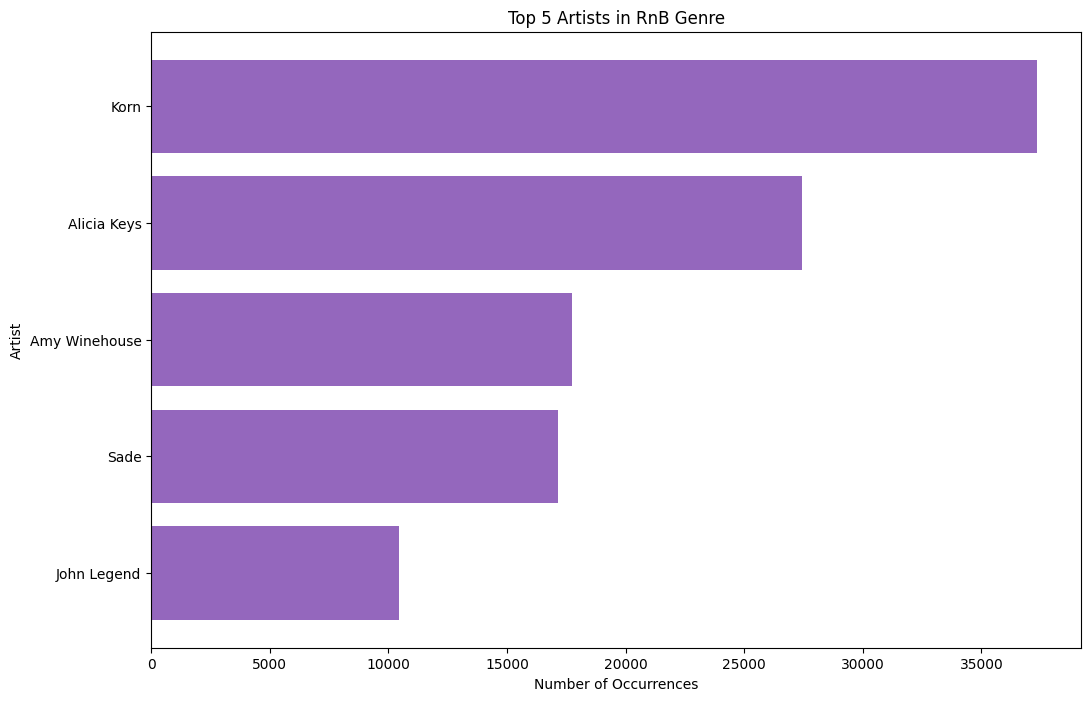

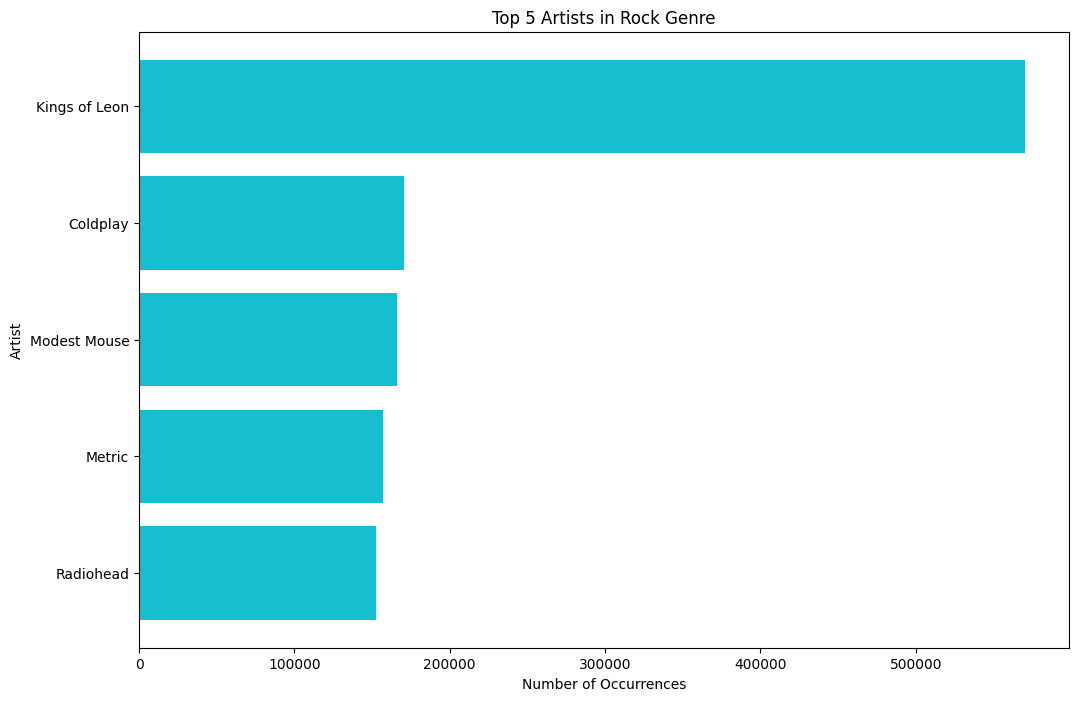

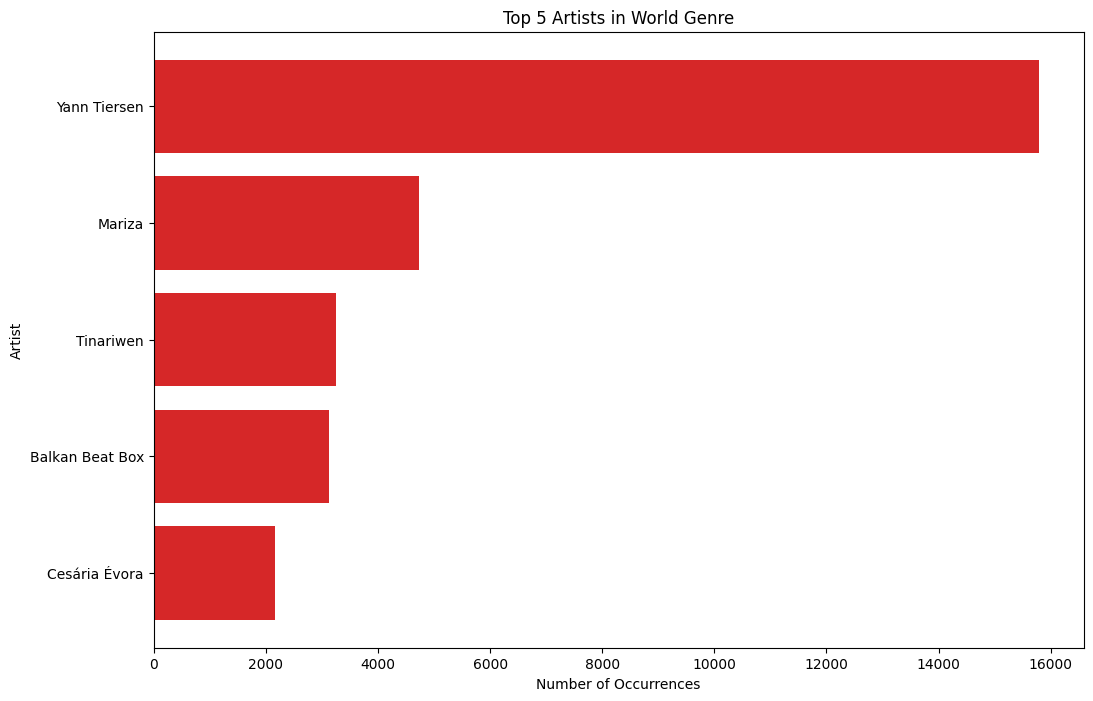

In [21]:
spark = SparkSession.builder.appName("MusicDataProcessing").getOrCreate()
file_path = "merged/merged_data.csv"

# Read data
df = spark.read.csv(file_path, header=True, inferSchema=True)

window_spec = Window.partitionBy("genre").orderBy(col("occurrences").desc())

# Tambah row number column untuk tiap partisi
df_with_row_number = df.withColumn("row_number", row_number().over(window_spec))

# Filter untuk mendapatkan top 5 untuk tiap genre
top_songs = df_with_row_number.filter(col("row_number") <= 5).drop("row_number")
top_songs.show()

# Grouping data untuk plotting
genre_data = top_songs.groupBy("genre").agg(collect_list("artist").alias("artists"), collect_list("occurrences").alias("occurrences")).collect()
genre_data_dict = {row['genre']: {'artists': row['artists'], 'occurrences': row['occurrences']} for row in genre_data}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Plot data
for genre, data in genre_data_dict.items():
    plt.figure(figsize=(12, 8))
    plt.barh(data['artists'], data['occurrences'], color=colors[randrange(0, len(colors))])
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Artist')
    plt.title(f'Top 5 Artists in {genre} Genre')
    plt.gca().invert_yaxis()
    plt.show()

# Stop the Spark session
spark.stop()